# 01 - Data Analysis and Preparation

This notebook covers the following tasks:

1. Perform exploratory data analysis and visualization.
2. Prepare the data for the ML task in BigQuery.
3. Generate and fix a ` TFDV schema` for the source data.
4. Create a `Vertex Dataset resource` dataset.


## Dataset

The [Chicago Taxi Trips](https://pantheon.corp.google.com/marketplace/details/city-of-chicago-public-data/chicago-taxi-trips) dataset is one of [public datasets hosted with BigQuery](https://cloud.google.com/bigquery/public-data/), which includes taxi trips from 2013 to the present, reported to the City of Chicago in its role as a regulatory agency. The `taxi_trips` table size is 70.72 GB and includes more than 195 million records. The dataset includes information about the trips, like pickup and dropoff datetime and location, passengers count, miles travelled, and trip toll. 

The ML task is to predict whether a given trip will result in a tip > 20%.

## Setup

### Import libraries

In [28]:
import os
#import pandas as pd
#import tensorflow as tf
import tensorflow_data_validation as tfdv
#from google.cloud import bigquery
#import matplotlib.pyplot as plt

#from google.cloud import aiplatform as vertex_ai

### Setup Google Cloud project

In [2]:
output=!gcloud config list --format 'value(core.project)'
PROJECT_ID=output[0]
REGION = 'us-central1'

### Set configurations

In [3]:
BQ_DATASET_NAME = 'public_dataset' # Change to your BQ dataset name.
BQ_TABLE_NAME = 'chicago_taxitrips_prep'
BQ_LOCATION = 'US'

DATASET_DISPLAY_NAME = 'chicago-taxi-tips'

RAW_SCHEMA_DIR = 'src/raw_schema'

## 1. Explore the data in BigQuery

In [4]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek
;

Downloading: 100%|██████████| 7/7 [00:02<00:00,  3.08rows/s]


In [5]:
data

,trip_dayofweek,trip_dayname,trip_count
0,1,Sunday,4141154
1,2,Monday,4105900
2,3,Tuesday,4378805
3,4,Wednesday,4542810
4,5,Thursday,4918190
5,6,Friday,5289830
6,7,Saturday,5009186


<AxesSubplot:xlabel='trip_dayname'>

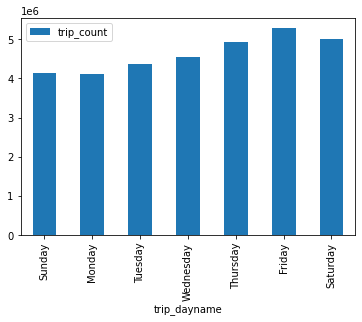

In [6]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

## 2. Create data for the ML task

We add a `ML_use` column for pre-splitting the data, where 80% of the datsa items are set to `UNASSIGNED` while the other 20% is set to `TEST`.

This column is used during training to split the dataset for training and test.

In the training phase, the `UNASSIGNED` are split into `train` and `eval`. The `TEST` split is will be used for the final model validation.

### Create destination BigQuery dataset

In [7]:
!bq --location=US mk -d \
$PROJECT:$BQ_DATASET_NAME

BigQuery error in mk operation: Cannot determine dataset described by :


In [8]:
sample_size = 1000000
year = 2020

In [ ]:
sql_script = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      CONCAT(
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickup_longitude,
              pickup_latitude), 0.1)), 
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropoff_longitude,
              dropoff_latitude), 0.1))
      ) AS loc_cross,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      IF(RAND() <= 0.8, 'UNASSIGNED', 'TEST') AS ML_use
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

In [ ]:
sql_script = sql_script.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

In [ ]:
print(sql_script)

In [ ]:
bq_client = bigquery.Client(project=PROJECT, location=BQ_LOCATION)
job = bq_client.query(sql_script)
_ = job.result()

In [ ]:
%%bigquery --project {PROJECT}

SELECT ML_use, COUNT(*)
FROM public_dataset.chicago_taxitrips_prep # Change to your BQ dataset and table names.
GROUP BY ML_use

### Load a sample data to a Pandas DataFrame

In [ ]:
sample_data.head().T

In [ ]:
sample_data.tip_bin.value_counts()

In [ ]:
sample_data.euclidean.hist()

# TFX Interactive

* [TFX Components Walk-through
Learning Objectives](https://notebook.community/GoogleCloudPlatform/mlops-on-gcp/workshops/tfx-caip-tf21/lab-01-tfx-walkthrough/lab-01) (MUST)



In [7]:
!rm -rf ./data/artifacts
!mkdir -p ./data/artifacts

In [8]:
import os
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

context = InteractiveContext(pipeline_root='./data/artifacts')

## BigQueryExampleGen

* [Colab InteractiveContext Unable to Determine ProjectID for BQ #882](https://github.com/tensorflow/tfx/issues/882)

> The issue appears when running this in a notebook with the BigQueryExampleGen with the error ```Request missing required parameter projectId```.  
> I have proposed [#888](https://github.com/tensorflow/tfx/pull/888) to make this work. With that change, you would be able to do 
> ```
> context.run(..., beam_pipeline_args=['--project', 'my-project'])
> ```

* [Allow beam_pipeline_args to be specified in interactive context.run(). #888](https://github.com/tensorflow/tfx/pull/888)
* [BigQueryExampleGen broken ReadFromBigQuery requires a GCS location to be provided #2293](https://github.com/tensorflow/tfx/issues/2293)

> need to provide --temp_location as part of the beam pipeline arg, and set that to a GCS location

* [ValueError in Dataflow: Invalid GCS location: None](https://stackoverflow.com/questions/68325195/valueerror-in-dataflow-invalid-gcs-location-none)

> When running your Dataflow pipeline pass the argument ```--temp_location gs://bucket/subfolder/```

## Tutorial

* [TensorFlow Extended (TFX): Using Apache Beam for large scale data processing](https://blog.tensorflow.org/2020/03/tensorflow-extended-tfx-using-apache-beam-large-scale-data-processing.html)
* [Reading data from BigQuery with TFX and Vertex Pipelines ](https://www.tensorflow.org/tfx/tutorials/tfx/gcp/vertex_pipelines_bq)

> This notebook-based tutorial will use Google Cloud BigQuery as a data source to train an ML model. The ML pipeline will be constructed using TFX and run on Google Cloud Vertex Pipelines. In this tutorial, we will use the **BigQueryExampleGen** component which reads data from BigQuery to TFX pipelines.  
> 
> 
> We also **need to pass beam_pipeline_args** for the BigQueryExampleGen. It includes configs like **the name of the GCP project and the temporary storage** for the BigQuery execution.


In [9]:
BUCKET = "gs://" + PROJECT_ID + "-bucket"
!gsutil mb $BUCKET

Creating gs://gcp-egl-ml-platform-dev-bucket/...
ServiceException: 409 A Cloud Storage bucket named 'gcp-egl-ml-platform-dev-bucket' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [10]:
from tfx.v1.extensions.google_cloud_big_query import BigQueryExampleGen
from tfx.v1.components import (
    StatisticsGen,
    SchemaGen,
)

In [14]:
query = """
SELECT 
    * EXCEPT (trip_start_timestamp, ML_use)
FROM 
    {PROJECT_ID}.public_dataset.chicago_taxitrips_prep
""".format(PROJECT_ID=PROJECT_ID)

example_gen = context.run(
    BigQueryExampleGen(query=query),
    beam_pipeline_args=[
        '--project', PROJECT_ID,
        '--temp_location', BUCKET
    ]
)

In [17]:
dir(example_gen)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'component',
 'execution_id']

## StatisticsGen

In [23]:
statistics_gen = context.run(
    StatisticsGen(examples=example_gen.component.outputs['examples'])
)
context.show(statistics_gen.component.outputs['statistics'])

## SchemaGen

* [Why isn't SchemaGen supported in tfdv.display_schema()?](https://stackoverflow.com/a/64199301)

In [22]:
schema_gen = SchemaGen(
    statistics=statistics_gen.component.outputs['statistics'],
    infer_feature_shape=True
)
context.run(schema_gen)
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'dropoff_grid',STRING,required,,'dropoff_grid'
'euclidean',FLOAT,required,,-
'loc_cross',BYTES,required,,-
'payment_type',STRING,required,,'payment_type'
'pickup_grid',STRING,required,,'pickup_grid'
'tip_bin',INT,required,,-
'trip_day',INT,required,,-
'trip_day_of_week',INT,required,,-
'trip_hour',INT,required,,-


,Values
Domain,
'dropoff_grid',"'POINT(-87.5 41.7)', 'POINT(-87.6 41.7)', 'POINT(-87.6 41.8)', 'POINT(-87.6 41.9)', 'POINT(-87.6 42)', 'POINT(-87.7 41.7)', 'POINT(-87.7 41.8)', 'POINT(-87.7 41.9)', 'POINT(-87.7 42)', 'POINT(-87.8 41.8)', 'POINT(-87.8 41.9)', 'POINT(-87.8 42)', 'POINT(-87.9 42)'"
'payment_type',"'Cash', 'Credit Card', 'Dispute', 'Mobile', 'No Charge', 'Prcard', 'Prepaid', 'Unknown'"
'pickup_grid',"'POINT(-87.5 41.7)', 'POINT(-87.6 41.7)', 'POINT(-87.6 41.8)', 'POINT(-87.6 41.9)', 'POINT(-87.6 42)', 'POINT(-87.7 41.7)', 'POINT(-87.7 41.8)', 'POINT(-87.7 41.9)', 'POINT(-87.7 42)', 'POINT(-87.8 41.8)', 'POINT(-87.8 41.9)', 'POINT(-87.8 42)', 'POINT(-87.9 42)'"


## 3. Generate raw data schema

The [TensorFlow Data Validation (TFDV)](https://www.tensorflow.org/tfx/data_validation/get_started) data schema will be used in:
1. Identify the raw data types and shapes in the data transformation.
2. Create the serving input signature for the custom model.
3. Validate the new raw training data in the TFX pipeline.

In [29]:

stats = tfdv.generate_statistics_from_dataframe(
    dataframe=sample_data,
    stats_options=tfdv.StatsOptions(
        label_feature='tip_bin',
        weight_feature=None,
        sample_rate=1,
        num_top_values=50
    )
)

NameError: name 'sample_data' is not defined

In [25]:
tfdv.visualize_statistics(stats)

NameError: name 'tfdv' is not defined

In [26]:
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

NameError: name 'tfdv' is not defined

In [27]:
raw_schema_location = os.path.join(RAW_SCHEMA_DIR, 'schema.pbtxt')
tfdv.write_schema_text(schema, raw_schema_location)

NameError: name 'tfdv' is not defined

## 4. Create Vertex Dataset resource

In [ ]:
vertex_ai.init(
    project=PROJECT,
    location=REGION
)

### Create the dataset resource

In [ ]:
bq_uri = f"bq://{PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME}"

dataset = vertex_ai.TabularDataset.create(
    display_name=DATASET_DISPLAY_NAME, bq_source=bq_uri)

dataset.gca_resource

### Get the dataset resource

The dataset resource is retrieved by display name. Because multiple datasets can have the same display name, we retrieve the most recent updated one.

In [ ]:
dataset = vertex_ai.TabularDataset.list(
    filter=f"display_name={DATASET_DISPLAY_NAME}", 
    order_by="update_time")[-1]

print("Dataset resource name:", dataset.resource_name)
print("Dataset BigQuery source:", dataset.gca_resource.metadata['inputConfig']['bigquerySource']['uri'])